# Spatial Autocorrelation

This notebook will demostrate a popular spatial analysis task which is to examine the spatial autocorrelation pattern. I will demostrate using data from US census bureau obtained through API and `census` package.

## Part 1 Census API

Install `census` and `us` package. The `us` package provides some convenient lookup to the FIPS code and boundary files.

In [1]:
#pip install -q census

In [2]:
#pip install -q us

Import the packages

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

from census import Census
import us

First, get yourself a Census API key from [here](https://api.census.gov/data/key_signup.html). This will require you to put your affliation and your email. Then you need to activate your API key through email. You will then get a long key string to replace what I have here:

In [4]:
census_api_key = "0ed8bfc03db7e7bf1b990114c59b0840650c4fc7" #Replace this with yours

c = Census(census_api_key)

Then we can use a function to automatically download census data and make it into a nicely formatted Dataframe.

Below is an example to fetch the county level data for variables:

*   Total population (B01003_001E)
*   Median monthly housing costs (B25105_001E)
*   Numbers of people who drive (van, truck, car) to work (B08134_011E)


This data is from the American Community Survey (ACS) which is an annual effort to sample a small portion of US addresses through questionaries and aggregate data into census products over multiple years. Most often, the 5-year estimate ACS has good coverage, more details can be seen here: https://www.census.gov/data/developers/data-sets/acs-5year.html

Lookup table for variables: https://api.census.gov/data/2019/acs/acs5/variables.html

In [5]:
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html

fl_census = c.acs5.state_county(fields = ('NAME', 'B01003_001E', 'B25105_001E', 'B08134_001E'), #variable names
                                      state_fips = '12', #state FIPS code for FL
                                      county_fips = "*", #"*" means all counties in the state
                                      year = 2019) # 2019 data


#Get tract level data
'''
fl_census = c.acs5.state_county_tract(fields = ('NAME', 'B01003_001E', 'B25105_001E', 'B08134_001E'), #variable names
                                      state_fips = '12', #state FIPS code for FL
                                      county_fips = "*", #"*" means all counties in the state
                                      tract = "*", #"*" means all tracts in the counties/state
                                      year = 2019) # 2019 data
'''

'\nfl_census = c.acs5.state_county_tract(fields = (\'NAME\', \'B01003_001E\', \'B25105_001E\', \'B08134_001E\'), #variable names\n                                      state_fips = \'12\', #state FIPS code for FL\n                                      county_fips = "*", #"*" means all counties in the state\n                                      tract = "*", #"*" means all tracts in the counties/state\n                                      year = 2019) # 2019 data\n'

Make the results a data frame.

In [6]:
fl_df = pd.DataFrame(fl_census)

In [7]:
fl_df

,NAME,B01003_001E,B25105_001E,B08134_001E,state,county
0,"Washington County, Florida",24764.0,581.0,8147.0,12,133
1,"Duval County, Florida",936186.0,1084.0,435422.0,12,031
2,"Bradford County, Florida",27317.0,656.0,9045.0,12,007
3,"Brevard County, Florida",585507.0,971.0,233536.0,12,009
4,"Clay County, Florida",211405.0,1091.0,91147.0,12,019
...,...,...,...,...,...,...
62,"Levy County, Florida",40403.0,570.0,14105.0,12,075
63,"Volusia County, Florida",536487.0,939.0,208321.0,12,127
64,"Madison County, Florida",18460.0,526.0,6010.0,12,079
65,"Escambia County, Florida",313491.0,930.0,131031.0,12,033


In [8]:
fl_df.head()

,NAME,B01003_001E,B25105_001E,B08134_001E,state,county
0,"Washington County, Florida",24764.0,581.0,8147.0,12,133
1,"Duval County, Florida",936186.0,1084.0,435422.0,12,031
2,"Bradford County, Florida",27317.0,656.0,9045.0,12,007
3,"Brevard County, Florida",585507.0,971.0,233536.0,12,009
4,"Clay County, Florida",211405.0,1091.0,91147.0,12,019


Make column names more intuitive.

In [9]:
fl_df = fl_df.rename(columns={
    "B01003_001E": "total_population",
    "B25105_001E": "monthly_housing_costs",
    "B08134_001E": "population_drive_to_work"
    })

In [10]:
fl_df.head()

,NAME,total_population,monthly_housing_costs,population_drive_to_work,state,county
0,"Washington County, Florida",24764.0,581.0,8147.0,12,133
1,"Duval County, Florida",936186.0,1084.0,435422.0,12,031
2,"Bradford County, Florida",27317.0,656.0,9045.0,12,007
3,"Brevard County, Florida",585507.0,971.0,233536.0,12,009
4,"Clay County, Florida",211405.0,1091.0,91147.0,12,019


## FIPS Code

Each census unit is identified by the FIPS (Federal Information Processing Standard) code

<img src="https://blog.cdxtech.com/Blog/image.axd?picture=2012%2F8%2FFIPS+CODE.png">

And most of the administrative data from varisous agencies should have this code.

# Obtain a boundary file from TIGER

A quick and easy way to directly fetch boundary from TIGER.

First we need to know the URL of the unit we want.

In [11]:
urls = us.states.FL.shapefile_urls()

urls.keys()

dict_keys(['tract', 'cd', 'county', 'state', 'zcta', 'block', 'blockgroup'])

This will return you with an URL, that you can pass into geopandas's `read_file`.

In [12]:
urls['county']

'https://www2.census.gov/geo/tiger/TIGER2010/COUNTY/2010/tl_2010_12_county10.zip'

Here, we are interested in the county level for Florida. *You are only  able to get the 2010 TIGER method using this method.

In [13]:
url = urls['county']

In [14]:
fl_county = gpd.read_file(url)

<Axes: >

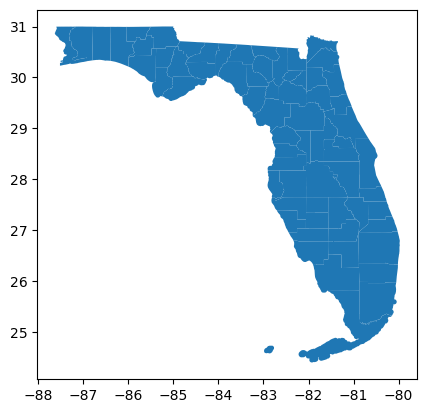

In [15]:
fl_county.plot()

In [16]:
fl_county.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [17]:
fl_county.head()

,STATEFP10,COUNTYFP10,COUNTYNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,CSAFP10,CBSAFP10,METDIVFP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,12,017,00295752,12017,Citrus,Citrus County,06,H1,G4020,None,26140,None,A,1506586255,496236304,+28.8436275,-082.5247964,"POLYGON ((-82.45142 28.69481, -82.45247 28.694..."
1,12,009,00295749,12009,Brevard,Brevard County,06,H1,G4020,None,37340,None,A,2630557912,1402040884,+28.2982755,-080.7003842,"POLYGON ((-80.49977 28.40954, -80.49989 28.409..."
2,12,037,00306911,12037,Franklin,Franklin County,06,H1,G4020,None,None,None,A,1384930964,1273675839,+29.8101756,-084.7991735,"POLYGON ((-85.02190 29.82354, -85.02224 29.823..."
3,12,011,00295753,12011,Broward,Broward County,06,H1,G4020,None,33100,22744,A,3133329108,292869341,+26.1935200,-080.4766578,"POLYGON ((-80.29693 26.33436, -80.29691 26.335..."
4,12,047,00295736,12047,Hamilton,Hamilton County,06,H1,G4020,None,None,None,A,1330711074,13638327,+30.4911024,-082.9510488,"POLYGON ((-83.05570 30.61947, -83.05100 30.619..."


The GeoDataFrame has FIPS code that we can use to join with the census data. Note that the `GEOID10` concatenates state and county (and tract/block if any) code together into a long code.

To make a consistent key, we need to create a new column in the census dataframe `fl_df` exactly the same as the `GEOID10` in `fl_county`.

In [18]:
fl_df.head()

,NAME,total_population,monthly_housing_costs,population_drive_to_work,state,county
0,"Washington County, Florida",24764.0,581.0,8147.0,12,133
1,"Duval County, Florida",936186.0,1084.0,435422.0,12,031
2,"Bradford County, Florida",27317.0,656.0,9045.0,12,007
3,"Brevard County, Florida",585507.0,971.0,233536.0,12,009
4,"Clay County, Florida",211405.0,1091.0,91147.0,12,019


In [19]:
fl_df["GEOID10"] = fl_df["state"] + fl_df["county"]

In [20]:
fl_df["GEOID10"]

0     12133
1     12031
2     12007
3     12009
4     12019
      ...  
62    12075
63    12127
64    12079
65    12033
66    12091
Name: GEOID10, Length: 67, dtype: object

Merge two dataframes based on the same key `GEOID10`.

In [21]:
fl_county_df = pd.merge(fl_county, fl_df,on="GEOID10")

In [22]:
fl_county_df.head()

,STATEFP10,COUNTYFP10,COUNTYNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,CSAFP10,...,AWATER10,INTPTLAT10,INTPTLON10,geometry,NAME,total_population,monthly_housing_costs,population_drive_to_work,state,county
0,12,017,00295752,12017,Citrus,Citrus County,06,H1,G4020,None,...,496236304,+28.8436275,-082.5247964,"POLYGON ((-82.45142 28.69481, -82.45247 28.694...","Citrus County, Florida",145169.0,639.0,42604.0,12,017
1,12,009,00295749,12009,Brevard,Brevard County,06,H1,G4020,None,...,1402040884,+28.2982755,-080.7003842,"POLYGON ((-80.49977 28.40954, -80.49989 28.409...","Brevard County, Florida",585507.0,971.0,233536.0,12,009
2,12,037,00306911,12037,Franklin,Franklin County,06,H1,G4020,None,...,1273675839,+29.8101756,-084.7991735,"POLYGON ((-85.02190 29.82354, -85.02224 29.823...","Franklin County, Florida",11811.0,644.0,4069.0,12,037
3,12,011,00295753,12011,Broward,Broward County,06,H1,G4020,None,...,292869341,+26.1935200,-080.4766578,"POLYGON ((-80.29693 26.33436, -80.29691 26.335...","Broward County, Florida",1926205.0,1356.0,898752.0,12,011
4,12,047,00295736,12047,Hamilton,Hamilton County,06,H1,G4020,None,...,13638327,+30.4911024,-082.9510488,"POLYGON ((-83.05570 30.61947, -83.05100 30.619...","Hamilton County, Florida",14326.0,490.0,3591.0,12,047


<Axes: >

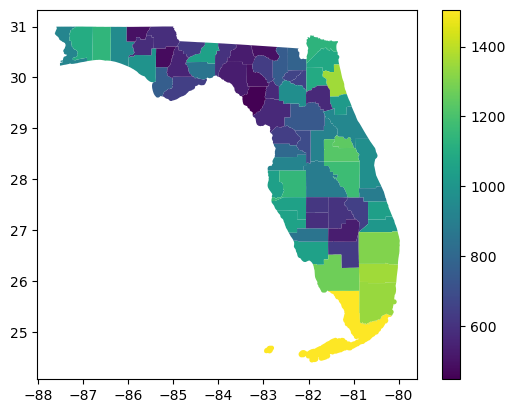

In [23]:
fl_county_df.plot(column="monthly_housing_costs",legend=True)

<Axes: >

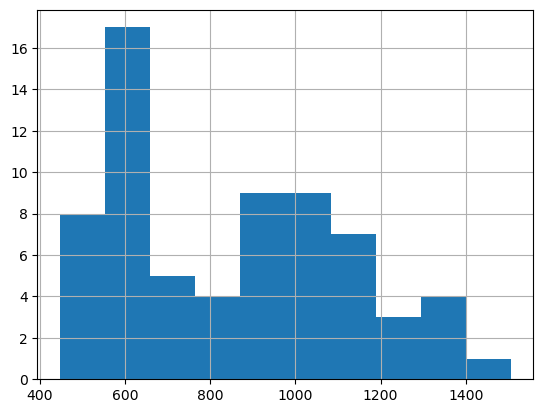

In [24]:
fl_county_df.monthly_housing_costs.hist()

Now let's look at the other variable, population drive to work. Here we can calculate the % of people drive to work and make a new column in the dataframe.

In [25]:
fl_county_df["pct_drive"] = fl_county_df["population_drive_to_work"]/fl_county_df["total_population"]*100

<Axes: >

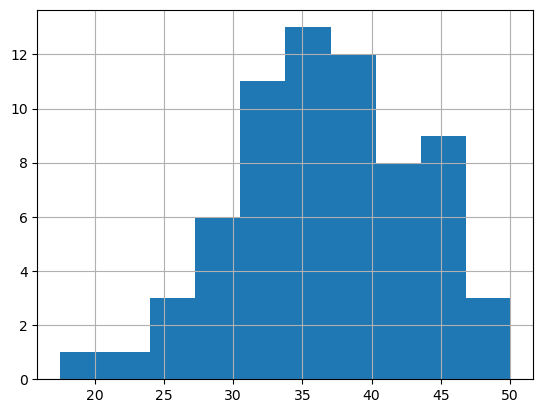

In [26]:
fl_county_df["pct_drive"].hist()

Text(0.5, 1.0, '% of People drive to work')

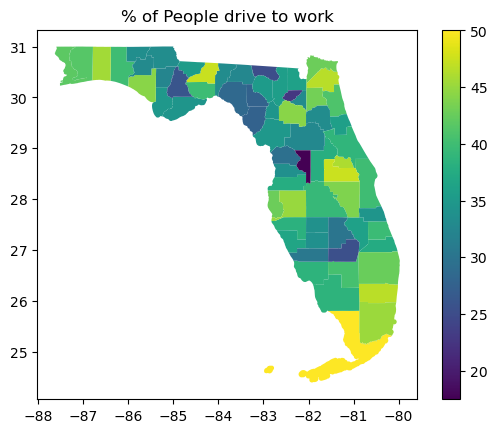

In [27]:
fl_county_df.plot(column="pct_drive",legend=True)

plt.title("% of People drive to work")

A simple scatterplot showing a positive correlation between the two variables.

Text(0, 0.5, 'Monthly Housing Costs')

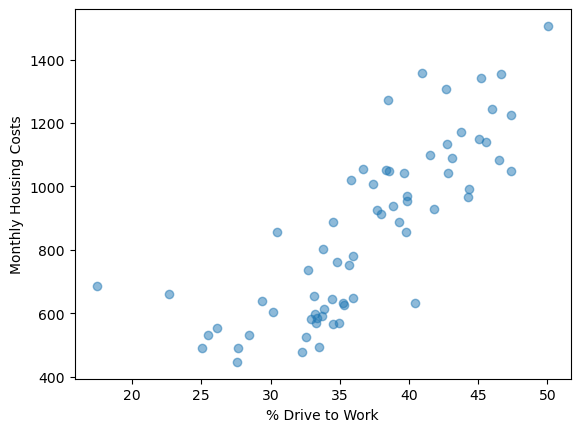

In [28]:
plt.scatter(fl_county_df["pct_drive"], fl_county_df["monthly_housing_costs"],alpha=0.5)

plt.xlabel("% Drive to Work")
plt.ylabel("Monthly Housing Costs")

## Part 2 Autocorrelation Analysis

- Global Moran's I
- Moran Scatterplot
- Local Moran's I (LISA)
- Bivariate LISA


If you have `pysal` installed, you may not need to install these

In [29]:
#pip install -q splot

In [30]:
#pip install -q libpysal

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd


from libpysal.weights.contiguity import Queen

from splot.esda import moran_scatterplot,plot_moran,lisa_cluster
from esda.moran import Moran, Moran_Local

import splot

## Global Moran's I and p-value

Specify a weight matrix

In [32]:
w = Queen.from_dataframe(fl_county_df) #Generate W matrix using Queen contiguity


#w = Rook.from_dataframe(fl_county_df) #Generate W matrix using Rook contiguity


w.transform = 'r' #Row-standardization of the weight matrix

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_40452/2304272244.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(fl_county_df) #Generate W matrix using Queen contiguity


Calculate Moran's I

In [33]:
from esda.moran import Moran

housing_costs = fl_county_df['monthly_housing_costs'].values #Get the data we are interested.


global_moran = Moran(housing_costs, w)

global_moran.I

0.4771382216983452

p-value

In [34]:
global_moran.p_sim # P value based on permutation tests

0.001

This is indicating that the observed positive spatial autocorrelation of the median housing costs map is statistically significant (p<0.05).

In other words, if we assume the pattern to be random, there is around ~0.5% probability that we will observe a pattern like our real data. so the spatial pattern is very unlikely to be random.  

## Moran Scatterplot

/Users/ziqili/anaconda3/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.48', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.48)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

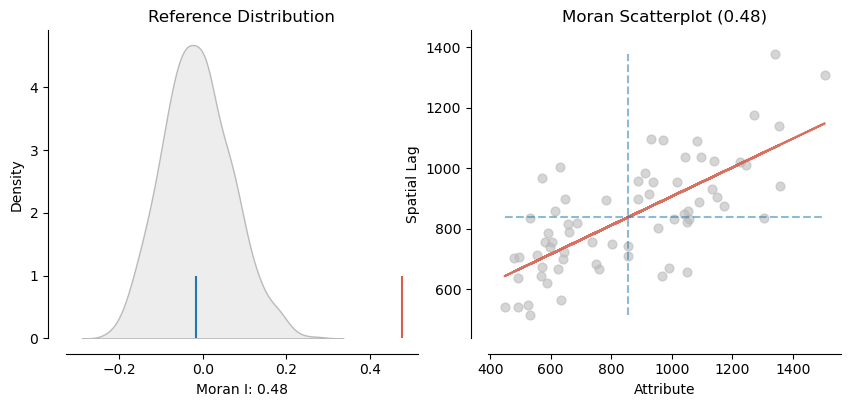

In [35]:
from splot.esda import plot_moran

plot_moran(global_moran, 
           zstandard=False, #True the data will be normalized (mean removed and divided by std)
           figsize=(10,4)
          )

The left is the null sampling distribution of Moran's I under assumption of spatial randomness. The blue bar is the position of expected Moran's I value (-1/(n-1)), and the red bar marks the observed Moran's I value (0.48).

The right is a Moran Scatterplot.

## Local Moran's I (LISA)

Generate a better Moran Scatterplot with significance of the local moran's Is.

Color code each county with the quadrant it falls into.
- Red: HH (High values near high values)
- Light Blue: LH
- Yellow: HL
- Blue: LL

Text(0, 0.5, 'Averaged Housing Costs in the Close Neighborhoods')

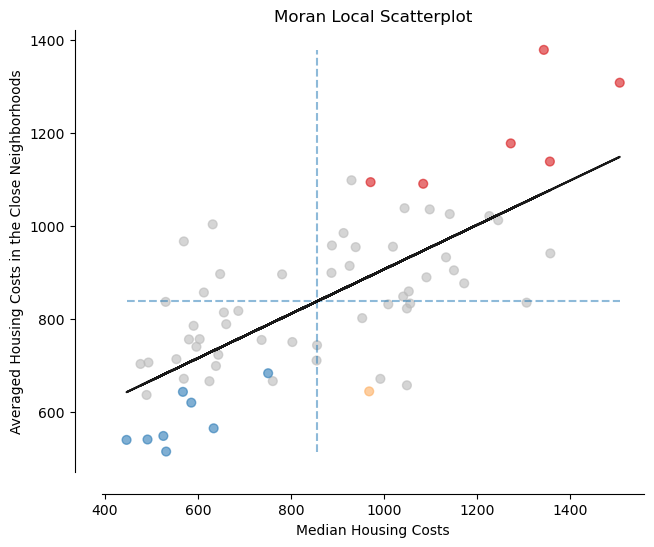

In [36]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_local = Moran_Local(housing_costs, w)

fig, ax = moran_scatterplot(moran_local, zstandard=False, p=0.05)

#Labelling
ax.set_xlabel('Median Housing Costs')
ax.set_ylabel('Averaged Housing Costs in the Close Neighborhoods')


Create a hot-spot and cold-spot map.
- HH: High % Bach county surrounded by High % Bach county
- LL: Low-Low
- LH: Low-High
- HL: High-Low
- NS: Non-significant (p>0.05)

(<Figure size 600x600 with 1 Axes>, <Axes: >)

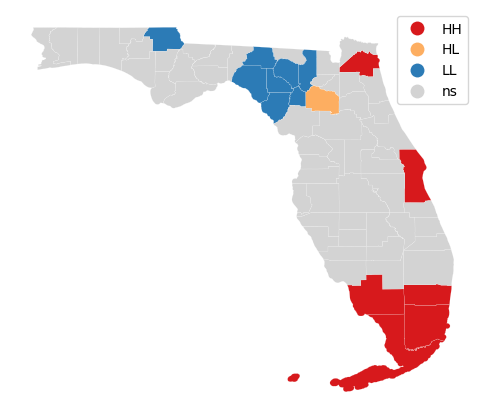

In [37]:
from splot.esda import lisa_cluster

lisa_cluster(moran_loc=moran_local, 
             gdf=fl_county_df, 
             p = 0.05, # the level of p-value threshold to mask for non-significance
             figsize = (6,6))

## Bivariate LISA

looking at pair-wise relationship between a variable and another variable (neighborhood-averaged)

In [38]:
from esda.moran import Moran_Local_BV

Text(0, 0.5, 'Averaged Housing Costs in the Close Neighborhood')

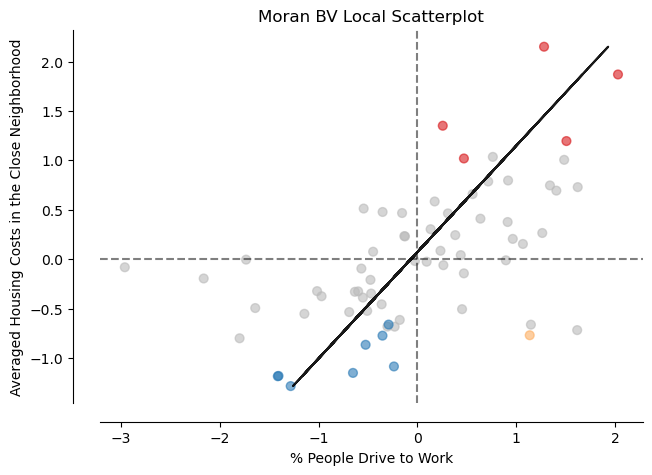

In [39]:
x = fl_county_df['pct_drive'].values
y = fl_county_df['monthly_housing_costs'].values

moran_loc_bv = Moran_Local_BV(x, y, w)

fig, ax = moran_scatterplot(moran_loc_bv, p=0.05,zstandard=False) #It seems the z-standard parameter is not working.


ax.set_xlabel('% People Drive to Work')
ax.set_ylabel('Averaged Housing Costs in the Close Neighborhood')

(<Figure size 600x600 with 1 Axes>, <Axes: >)

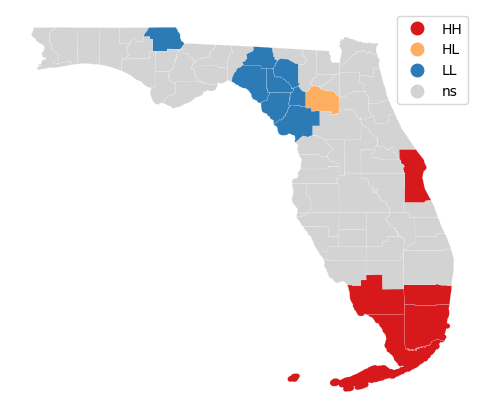

In [40]:
from splot.esda import plot_local_autocorrelation

lisa_cluster(moran_loc=moran_loc_bv, 
             gdf=fl_county_df, 
             p = 0.05, # the level of p-value threshold to mask for non-significance
             figsize = (6,6))

Bi-variate hot-spot interpretations

- HH: More people drive to work and high averaged housing costs.
- LL: Fewer people drive to work and low housing costs.
- LH: Fewer people drive to work and high housing costs.
- HL: More people drive to work and low housing costs.